# TEKNIK PENGAMBILAN DAN INTEGRITAS DATA

## Pengambilan Data


In [ ]:
import pandas as pd
import os

base_path = "/content"
files = os.listdir(base_path)

csv_files = [f for f in files if f.endswith('.csv')]
excel_files = [f for f in files if f.endswith('.xlsx')]

print("CSV ditemukan:", csv_files)
print("Excel ditemukan:", excel_files)

CSV ditemukan: ['TPT_Age.csv', 'Data_penggangguran.csv', 'Data_Pendidikan.csv', 'TPT_Gender.csv']
Excel ditemukan: []


In [ ]:
import pandas as pd

df1 = pd.read_csv("Data_Pendidikan.csv")
df2 = pd.read_csv("Data_penggangguran.csv")
df3 = pd.read_csv("TPT_Age.csv")
df4 = pd.read_csv("TPT_Gender.csv")

print("=== Tabel Data 1 ===")
print(df1.head())
print("\n=== Tabel Data 2 ===")
print(df2.head())
print("\n=== Tabel Data 3 ===")
print(df3.head())
print("\n=== Tabel Data 4 ===")
print(df4.head())


=== Tabel Data 1 ===
   Periode     Bulan  Tidak/belum pernah sekolah  Tidak/belum tamat SD  \
0     2006  Februari                      234465                614960   
1     2006   Agustus                      170666                611254   
2     2007  Februari                      145750                520316   
3     2007   Agustus                       94301                438519   
4     2008  Februari                       79764                448431   

        SD     SLTP  SLTA Umum/SMU  SLTA Kejuruan/SMK  Akademi/Diploma  \
0  2675459  2860007        2842876            1204140           297185   
1  2589699  2730045        2851518            1305190           278074   
2  2753548  2643062        2630360            1114675           330316   
3  2179792  2264198        2532204            1538349           397191   
4  2216748  2166619        2204377            1165582           519867   

   Universitas     Total  
0       375601  11104693  
1       395554  10932000  
2       

## Integrasi Data


In [ ]:
import pandas as pd

tpt_age = pd.read_csv("TPT_Age.csv")
pendidikan = pd.read_csv("Data_Pendidikan.csv")
tpt_gender = pd.read_csv("TPT_Gender.csv")
pengangguran = pd.read_csv("Data_penggangguran.csv")
tpt_age["TPT"] = pd.to_numeric(tpt_age["TPT"], errors="coerce")
tpt_age_pivot = (
    tpt_age
    .pivot_table(index="Year", columns="Kelompok_Umur", values="TPT")
    .reset_index()
)
for col in pendidikan.columns:
    if col not in ["Periode", "Bulan"]:
        pendidikan[col] = pd.to_numeric(pendidikan[col], errors="coerce")
pendidikan_mean = (
    pendidikan
    .groupby("Periode")
    .mean(numeric_only=True)
    .reset_index()
    .rename(columns={"Periode": "Year"})
)
tpt_gender["Laki - Laki"] = pd.to_numeric(tpt_gender["Laki - Laki"], errors="coerce")
tpt_gender["Perempuan"] = pd.to_numeric(tpt_gender["Perempuan"], errors="coerce")

pengangguran["Year"] = pd.to_datetime(pengangguran["Date"], errors='coerce').dt.year
pengangguran["Value"] = (
    pengangguran["Value"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .astype(float)
)
pengangguran = pengangguran[["Year", "Value"]]

/tmp/ipython-input-834420094.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pengangguran["Year"] = pd.to_datetime(pengangguran["Date"], errors='coerce').dt.year


In [ ]:
merged = (
    tpt_age_pivot
    .merge(pendidikan_mean, on="Year", how="outer")
    .merge(tpt_gender, on="Year", how="outer")
    .merge(pengangguran, on="Year", how="outer")
)

merged = merged[(merged["Year"] >= 2015) & (merged["Year"] <= 2022)]


In [ ]:
def combine_cols(df, cols, new_name):
    existing = [c for c in cols if c in df.columns]
    if len(existing) > 1:
        df[new_name] = df[existing].bfill(axis=1).iloc[:, 0]
        df.drop(columns=existing, inplace=True)
    elif len(existing) == 1:
        df.rename(columns={existing[0]: new_name}, inplace=True)

combine_cols(merged, ["60-above", "60 keatas"], "60 Keatas")
combine_cols(merged, ["Mean", "Rata-Rata"], "Rata-Rata")


In [ ]:
cols = list(merged.columns)

if "55-59" in cols and "60 Keatas" in cols:
    cols.insert(cols.index("55-59") + 1, cols.pop(cols.index("60 Keatas")))

if "Rata-Rata" in cols and "60 Keatas" in cols:
    cols.insert(cols.index("60 Keatas") + 1, cols.pop(cols.index("Rata-Rata")))

merged = merged[cols]
merged.to_csv("Data_Terintegrasi_2015_2022.csv", index=False)
print("Integrasi selesai! Kolom 60 Keatas & Rata-Rata sudah diatur posisinya.")
print(merged.head(10))



Integrasi selesai! Kolom 60 Keatas & Rata-Rata sudah diatur posisinya.
    Year  15-19  20-24  25-29  30-34  35-39  40-44  45-49  50-54  55-59  ...  \
33  2015  17.71  12.86  10.65   8.86   7.86   7.59   6.97   5.93   6.05  ...   
34  2016  28.09  15.80   7.08   3.63   2.21   2.05   1.35   1.66   1.55  ...   
35  2017  27.54  16.62   6.76   3.40   2.45   1.86   1.51   1.54   1.73  ...   
36  2018  26.93  16.79   6.97   3.44   2.48   1.80   1.58   1.39   1.25  ...   
37  2019  26.12  15.64   7.19   3.52   2.25   2.06   1.81   1.65   1.30  ...   
38  2020  24.34  18.71   9.77   5.75   4.32   3.92   3.54   3.61   3.21  ...   
39  2021  23.91  17.73   9.26   5.43   4.02   3.42   3.30   2.18   1.98  ...   
40  2022  29.08  17.02   7.13   3.70   2.65   2.43   2.33   2.38   2.37  ...   

           SD          SLTP  SLTA Umum/SMU  SLTA Kejuruan/SMK  \
33  1162676.5  1.512153e+06   2.021220e+06          1372028.0   
34  1127342.5  1.304149e+06   1.748662e+06          1434438.0   
35  1098397.5

## Cleaning Data


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("Data_Terintegrasi_2015_2022.csv")

print("=== Data Awal ===")
print(df.head(), "\n")


df.columns = df.columns.str.strip().str.replace('[^A-Za-z0-9_]', '_', regex=True)
for col in df.columns:
    if col != 'Year':
        df[col] = pd.to_numeric(df[col], errors='coerce')
print("=== Jumlah Missing Value per Kolom ===")
print(df.isna().sum(), "\n")

df = df.fillna(0)
df = df.drop_duplicates()

df = df[(df['Year'] >= 2015) & (df['Year'] <= 2022)]
df = df.round(2)

print("=== Statistik Ringkas Setelah Cleaning ===")
print(df.describe(), "\n")

df.to_csv("Data_Terintegrasi_2015_2022_CLEAN.csv", index=False)
print(" Data berhasil dibersihkan dan disimpan sebagai 'Data_Terintegrasi_2015_2022_CLEAN.csv'")


=== Data Awal ===
   Year  15-19  20-24  25-29  30-34  35-39  40-44  45-49  50-54  55-59  ...  \
0  2015  17.71  12.86  10.65   8.86   7.86   7.59   6.97   5.93   6.05  ...   
1  2016  28.09  15.80   7.08   3.63   2.21   2.05   1.35   1.66   1.55  ...   
2  2017  27.54  16.62   6.76   3.40   2.45   1.86   1.51   1.54   1.73  ...   
3  2018  26.93  16.79   6.97   3.44   2.48   1.80   1.58   1.39   1.25  ...   
4  2019  26.12  15.64   7.19   3.52   2.25   2.06   1.81   1.65   1.30  ...   

          SD       SLTP  SLTA Umum/SMU  SLTA Kejuruan/SMK  Akademi/Diploma  \
0  1162676.5  1512153.0      2021220.0          1372028.0         252926.5   
1  1127342.5  1304149.0      1748662.5          1434438.0         234549.0   
2  1098397.5  1277828.5      1731861.5          1502212.0         246321.0   
3   941944.5  1203794.5      1809213.5          1598790.5         264100.0   
4   915709.5  1186197.0      1849281.0          1568453.0         246665.5   

   Universitas      Total  Laki - Laki

# EXPLORATORY DATA ANALYSIS

In [ ]:
data = pd.read_csv("Data_Terintegrasi_2015_2022_CLEAN.csv")
data.head()

,Year,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,...,SD,SLTP,SLTA_Umum_SMU,SLTA_Kejuruan_SMK,Akademi_Diploma,Universitas,Total,Laki___Laki,Perempuan,Value
0,2015,17.71,12.86,10.65,8.86,7.86,7.59,6.97,5.93,6.05,...,1162676.5,1512153.0,2021220.0,1372028.0,252926.5,609494.0,7507794.5,6.07,6.37,4.51
1,2016,28.09,15.80,7.08,3.63,2.21,2.05,1.35,1.66,1.55,...,1127342.5,1304149.0,1748662.5,1434438.0,234549.0,631269.5,7027973.5,5.70,5.45,4.30
2,2017,27.54,16.62,6.76,3.40,2.45,1.86,1.51,1.54,1.73,...,1098397.5,1277828.5,1731861.5,1502212.0,246321.0,612848.5,7005262.0,5.53,5.44,3.78
3,2018,26.93,16.79,6.97,3.44,2.48,1.80,1.58,1.39,1.25,...,941944.5,1203794.5,1809213.5,1598790.5,264100.0,771997.0,7018421.0,5.34,5.25,4.39
4,2019,26.12,15.64,7.19,3.52,2.25,2.06,1.81,1.65,1.30,...,915709.5,1186197.0,1849281.0,1568453.0,246665.5,801104.0,7001610.0,5.24,5.22,3.59


## Exploring Table

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        8 non-null      int64  
 1   15_19                       8 non-null      float64
 2   20_24                       8 non-null      float64
 3   25_29                       8 non-null      float64
 4   30_34                       8 non-null      float64
 5   35_39                       8 non-null      float64
 6   40_44                       8 non-null      float64
 7   45_49                       8 non-null      float64
 8   50_54                       8 non-null      float64
 9   55_59                       8 non-null      float64
 10  60_Keatas                   8 non-null      float64
 11  Tidak_belum_pernah_sekolah  8 non-null      float64
 12  Tidak_belum_tamat_SD        8 non-null      float64
 13  SD                          8 non-null 

In [ ]:
print("\nBaris dan Kolom :", data.shape)


Baris dan Kolom : (8, 23)


In [ ]:
print("\nNama Kolom:", list(data.columns))


Nama Kolom: ['Year', '15_19', '20_24', '25_29', '30_34', '35_39', '40_44', '45_49', '50_54', '55_59', '60_Keatas', 'Tidak_belum_pernah_sekolah', 'Tidak_belum_tamat_SD', 'SD', 'SLTP', 'SLTA_Umum_SMU', 'SLTA_Kejuruan_SMK', 'Akademi_Diploma', 'Universitas', 'Total', 'Laki___Laki', 'Perempuan', 'Value']


In [ ]:
print(data.describe())

             Year      15_19      20_24      25_29     30_34     35_39  \
count     8.00000   8.000000   8.000000   8.000000  8.000000  8.000000   
mean   2018.50000  25.465000  16.396250   8.101250  4.716250  3.530000   
std       2.44949   3.598877   1.738595   1.536177  1.918101  1.928626   
min    2015.00000  17.710000  12.860000   6.760000  3.400000  2.210000   
25%    2016.75000  24.232500  15.760000   7.052500  3.500000  2.400000   
50%    2018.50000  26.525000  16.705000   7.160000  3.665000  2.565000   
75%    2020.25000  27.677500  17.197500   9.387500  5.510000  4.095000   
max    2022.00000  29.080000  18.710000  10.650000  8.860000  7.860000   

          40_44     45_49     50_54     55_59  ...            SD  \
count  8.000000  8.000000  8.000000  8.000000  ...  8.000000e+00   
mean   3.141250  2.798750  2.542500  2.430000  ...  1.127618e+06   
std    1.956012  1.876261  1.543704  1.596988  ...  1.401428e+05   
min    1.800000  1.350000  1.390000  1.250000  ...  9.157095e

Sorting Data

In [ ]:
df_sorted_age = data.sort_values(by='15_19', ascending=False)
df_sorted_age

,Year,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,...,SD,SLTP,SLTA_Umum_SMU,SLTA_Kejuruan_SMK,Akademi_Diploma,Universitas,Total,Laki___Laki,Perempuan,Value
7,2022,29.08,17.02,7.13,3.70,2.65,2.43,2.33,2.38,2.37,...,1259740.0,1487278.33,2402634.67,1733215.0,184779.67,743913.0,8418005.0,5.93,5.75,3.46
1,2016,28.09,15.80,7.08,3.63,2.21,2.05,1.35,1.66,1.55,...,1127342.5,1304149.00,1748662.50,1434438.0,234549.00,631269.5,7027973.5,5.70,5.45,4.30
2,2017,27.54,16.62,6.76,3.40,2.45,1.86,1.51,1.54,1.73,...,1098397.5,1277828.50,1731861.50,1502212.0,246321.00,612848.5,7005262.0,5.53,5.44,3.78
3,2018,26.93,16.79,6.97,3.44,2.48,1.80,1.58,1.39,1.25,...,941944.5,1203794.50,1809213.50,1598790.5,264100.00,771997.0,7018421.0,5.34,5.25,4.39
4,2019,26.12,15.64,7.19,3.52,2.25,2.06,1.81,1.65,1.30,...,915709.5,1186197.00,1849281.00,1568453.0,246665.50,801104.0,7001610.0,5.24,5.22,3.59
5,2020,24.34,18.71,9.77,5.75,4.32,3.92,3.54,3.61,3.21,...,1208640.5,1436435.00,2205639.00,1885060.5,286422.00,903057.5,8346620.0,7.46,6.46,4.26
6,2021,23.91,17.73,9.26,5.43,4.02,3.42,3.30,2.18,1.98,...,1306493.0,1559768.50,2388976.00,2100237.5,235240.50,924100.0,8924030.0,6.74,6.11,3.83
0,2015,17.71,12.86,10.65,8.86,7.86,7.59,6.97,5.93,6.05,...,1162676.5,1512153.00,2021220.00,1372028.0,252926.50,609494.0,7507794.5,6.07,6.37,4.51


In [ ]:
df_sorted_gender = data.sort_values(by='Perempuan', ascending=False)
df_sorted_gender

,Year,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,...,SD,SLTP,SLTA_Umum_SMU,SLTA_Kejuruan_SMK,Akademi_Diploma,Universitas,Total,Laki___Laki,Perempuan,Value
5,2020,24.34,18.71,9.77,5.75,4.32,3.92,3.54,3.61,3.21,...,1208640.5,1436435.00,2205639.00,1885060.5,286422.00,903057.5,8346620.0,7.46,6.46,4.26
0,2015,17.71,12.86,10.65,8.86,7.86,7.59,6.97,5.93,6.05,...,1162676.5,1512153.00,2021220.00,1372028.0,252926.50,609494.0,7507794.5,6.07,6.37,4.51
6,2021,23.91,17.73,9.26,5.43,4.02,3.42,3.30,2.18,1.98,...,1306493.0,1559768.50,2388976.00,2100237.5,235240.50,924100.0,8924030.0,6.74,6.11,3.83
7,2022,29.08,17.02,7.13,3.70,2.65,2.43,2.33,2.38,2.37,...,1259740.0,1487278.33,2402634.67,1733215.0,184779.67,743913.0,8418005.0,5.93,5.75,3.46
1,2016,28.09,15.80,7.08,3.63,2.21,2.05,1.35,1.66,1.55,...,1127342.5,1304149.00,1748662.50,1434438.0,234549.00,631269.5,7027973.5,5.70,5.45,4.30
2,2017,27.54,16.62,6.76,3.40,2.45,1.86,1.51,1.54,1.73,...,1098397.5,1277828.50,1731861.50,1502212.0,246321.00,612848.5,7005262.0,5.53,5.44,3.78
3,2018,26.93,16.79,6.97,3.44,2.48,1.80,1.58,1.39,1.25,...,941944.5,1203794.50,1809213.50,1598790.5,264100.00,771997.0,7018421.0,5.34,5.25,4.39
4,2019,26.12,15.64,7.19,3.52,2.25,2.06,1.81,1.65,1.30,...,915709.5,1186197.00,1849281.00,1568453.0,246665.50,801104.0,7001610.0,5.24,5.22,3.59


In [ ]:
df_sorted_education = data.sort_values(by='SLTA_Umum_SMU', ascending=False)
df_sorted_education

,Year,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,...,SD,SLTP,SLTA_Umum_SMU,SLTA_Kejuruan_SMK,Akademi_Diploma,Universitas,Total,Laki___Laki,Perempuan,Value
7,2022,29.08,17.02,7.13,3.70,2.65,2.43,2.33,2.38,2.37,...,1259740.0,1487278.33,2402634.67,1733215.0,184779.67,743913.0,8418005.0,5.93,5.75,3.46
6,2021,23.91,17.73,9.26,5.43,4.02,3.42,3.30,2.18,1.98,...,1306493.0,1559768.50,2388976.00,2100237.5,235240.50,924100.0,8924030.0,6.74,6.11,3.83
5,2020,24.34,18.71,9.77,5.75,4.32,3.92,3.54,3.61,3.21,...,1208640.5,1436435.00,2205639.00,1885060.5,286422.00,903057.5,8346620.0,7.46,6.46,4.26
0,2015,17.71,12.86,10.65,8.86,7.86,7.59,6.97,5.93,6.05,...,1162676.5,1512153.00,2021220.00,1372028.0,252926.50,609494.0,7507794.5,6.07,6.37,4.51
4,2019,26.12,15.64,7.19,3.52,2.25,2.06,1.81,1.65,1.30,...,915709.5,1186197.00,1849281.00,1568453.0,246665.50,801104.0,7001610.0,5.24,5.22,3.59
3,2018,26.93,16.79,6.97,3.44,2.48,1.80,1.58,1.39,1.25,...,941944.5,1203794.50,1809213.50,1598790.5,264100.00,771997.0,7018421.0,5.34,5.25,4.39
1,2016,28.09,15.80,7.08,3.63,2.21,2.05,1.35,1.66,1.55,...,1127342.5,1304149.00,1748662.50,1434438.0,234549.00,631269.5,7027973.5,5.70,5.45,4.30
2,2017,27.54,16.62,6.76,3.40,2.45,1.86,1.51,1.54,1.73,...,1098397.5,1277828.50,1731861.50,1502212.0,246321.00,612848.5,7005262.0,5.53,5.44,3.78


Aggregating Data

In [ ]:
faktor_pendidikan = ['Tidak_belum_pernah_sekolah',	'Tidak_belum_tamat_SD', 'SD','SLTP','SLTA_Umum_SMU','SLTA_Kejuruan_SMK',
        'Akademi_Diploma','Universitas']
data[faktor_pendidikan].agg(['min', 'max', 'mean', 'median'])

,Tidak_belum_pernah_sekolah,Tidak_belum_tamat_SD,SD,SLTP,SLTA_Umum_SMU,SLTA_Kejuruan_SMK,Akademi_Diploma,Universitas
min,18421.33000,387031.5000,915709.5,1.186197e+06,1.731862e+06,1.372028e+06,184779.67000,609494.0000
max,89928.50000,588023.0000,1306493.0,1.559768e+06,2.402635e+06,2.100238e+06,286422.00000,924100.0000
mean,49400.47875,447848.0625,1127618.0,1.370950e+06,2.019686e+06,1.649304e+06,243875.52125,749722.9375
median,38312.00000,433173.5000,1145009.5,1.370292e+06,1.935250e+06,1.583622e+06,246493.25000,757955.0000


In [ ]:
faktor_usia = ['15_19',	'20_24', '25_29',	'30_34',	'35_39',	'40_44',	'45_49',	'50_54',	'55_59',	'60_Keatas']
data[faktor_usia].agg(['min', 'max', 'mean', 'median'])

,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_Keatas
min,17.710,12.86000,6.76000,3.40000,2.210,1.80000,1.35000,1.3900,1.250,0.6100
max,29.080,18.71000,10.65000,8.86000,7.860,7.59000,6.97000,5.9300,6.050,4.7400
mean,25.465,16.39625,8.10125,4.71625,3.530,3.14125,2.79875,2.5425,2.430,2.0425
median,26.525,16.70500,7.16000,3.66500,2.565,2.24500,2.07000,1.9200,1.855,1.6100


In [ ]:
faktor_gender = ['Laki___Laki',	'Perempuan']
data[faktor_gender].agg(['min', 'max', 'mean', 'median'])

,Laki___Laki,Perempuan
min,5.24000,5.22000
max,7.46000,6.46000
mean,6.00125,5.75625
median,5.81500,5.60000


## Cek Missing Values dan Duplikat

In [ ]:
print("\nJumlah Missing Values Tiap Kolom:")
print(data.isna().sum())


Jumlah Missing Values Tiap Kolom:
Year                          0
15_19                         0
20_24                         0
25_29                         0
30_34                         0
35_39                         0
40_44                         0
45_49                         0
50_54                         0
55_59                         0
60_Keatas                     0
Tidak_belum_pernah_sekolah    0
Tidak_belum_tamat_SD          0
SD                            0
SLTP                          0
SLTA_Umum_SMU                 0
SLTA_Kejuruan_SMK             0
Akademi_Diploma               0
Universitas                   0
Total                         0
Laki___Laki                   0
Perempuan                     0
Value                         0
dtype: int64


In [ ]:
print("\nJumlah Data Duplikat:", data.duplicated().sum())


Jumlah Data Duplikat: 0


## Finding Outlier

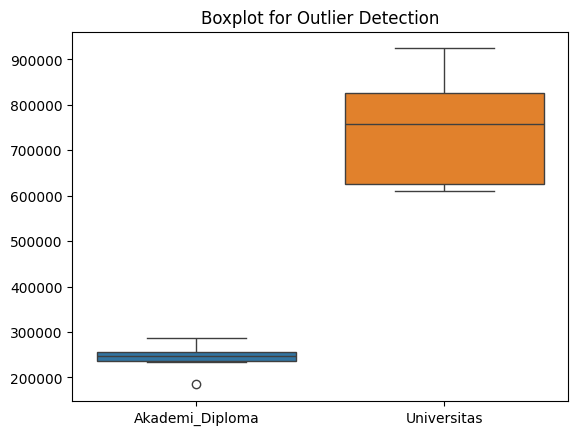

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=data[['Akademi_Diploma','Universitas']])
plt.title("Boxplot for Outlier Detection")
plt.show()

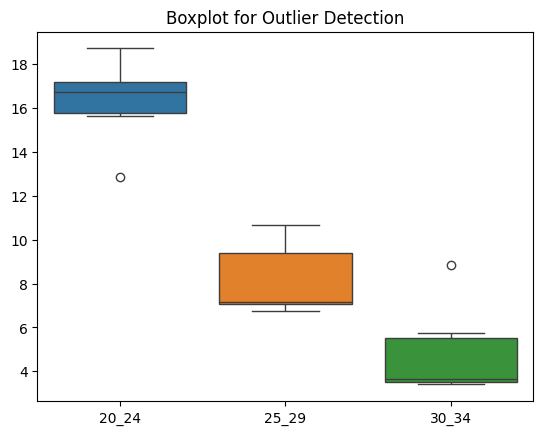

In [ ]:
sns.boxplot(data=data[['20_24','25_29','30_34']])
plt.title("Boxplot for Outlier Detection")
plt.show()

## Identifying Correlation

In [ ]:
age_cols = ['15_19','20_24','25_29','30_34','35_39','40_44',
            '45_49','50_54','55_59','60_Keatas']

data[age_cols].corr()

,15_19,20_24,25_29,30_34,35_39,40_44,45_49,50_54,55_59,60_Keatas
15_19,1.000000,0.547551,-0.895975,-0.958531,-0.956932,-0.945225,-0.942859,-0.878509,-0.862485,-0.704088
20_24,0.547551,1.000000,-0.195756,-0.479279,-0.523162,-0.560738,-0.517466,-0.509441,-0.559597,-0.497382
25_29,-0.895975,-0.195756,1.000000,0.945861,0.912663,0.902732,0.911599,0.874466,0.830796,0.711699
30_34,-0.958531,-0.479279,0.945861,1.000000,0.993616,0.991453,0.988141,0.958349,0.945864,0.832228
35_39,-0.956932,-0.523162,0.912663,0.993616,1.000000,0.994334,0.993070,0.963346,0.961324,0.845805
40_44,-0.945225,-0.560738,0.902732,0.991453,0.994334,1.000000,0.994285,0.978130,0.973690,0.857825
45_49,-0.942859,-0.517466,0.911599,0.988141,0.993070,0.994285,1.000000,0.970342,0.963696,0.866661
50_54,-0.878509,-0.509441,0.874466,0.958349,0.963346,0.978130,0.970342,1.000000,0.991781,0.832556
55_59,-0.862485,-0.559597,0.830796,0.945864,0.961324,0.973690,0.963696,0.991781,1.000000,0.867297
60_Keatas,-0.704088,-0.497382,0.711699,0.832228,0.845805,0.857825,0.866661,0.832556,0.867297,1.000000


In [ ]:
edu_cols = ['Tidak_belum_pernah_sekolah','Tidak_belum_tamat_SD','SD','SLTP',
            'SLTA_Umum_SMU','SLTA_Kejuruan_SMK','Akademi_Diploma','Universitas']

data[edu_cols].corr()

,Tidak_belum_pernah_sekolah,Tidak_belum_tamat_SD,SD,SLTP,SLTA_Umum_SMU,SLTA_Kejuruan_SMK,Akademi_Diploma,Universitas
Tidak_belum_pernah_sekolah,1.000000,0.179546,-0.193062,-0.163330,-0.665173,-0.808214,0.231360,-0.847899
Tidak_belum_tamat_SD,0.179546,1.000000,0.356956,0.295748,0.191862,-0.347971,-0.779991,-0.585094
SD,-0.193062,0.356956,1.000000,0.925743,0.785476,0.549486,-0.349201,0.219548
SLTP,-0.163330,0.295748,0.925743,1.000000,0.835394,0.490962,-0.266640,0.234620
SLTA_Umum_SMU,-0.665173,0.191862,0.785476,0.835394,1.000000,0.765863,-0.363981,0.606688
SLTA_Kejuruan_SMK,-0.808214,-0.347971,0.549486,0.490962,0.765863,1.000000,-0.018671,0.902418
Akademi_Diploma,0.231360,-0.779991,-0.349201,-0.266640,-0.363981,-0.018671,1.000000,0.213400
Universitas,-0.847899,-0.585094,0.219548,0.234620,0.606688,0.902418,0.213400,1.000000


In [ ]:
gender_cols = ['Laki___Laki','Perempuan']

data[gender_cols].corr()

,Laki___Laki,Perempuan
Laki___Laki,1.00000,0.87732
Perempuan,0.87732,1.00000


Visualisasi Hetmap

## Visualisasi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Line Chart

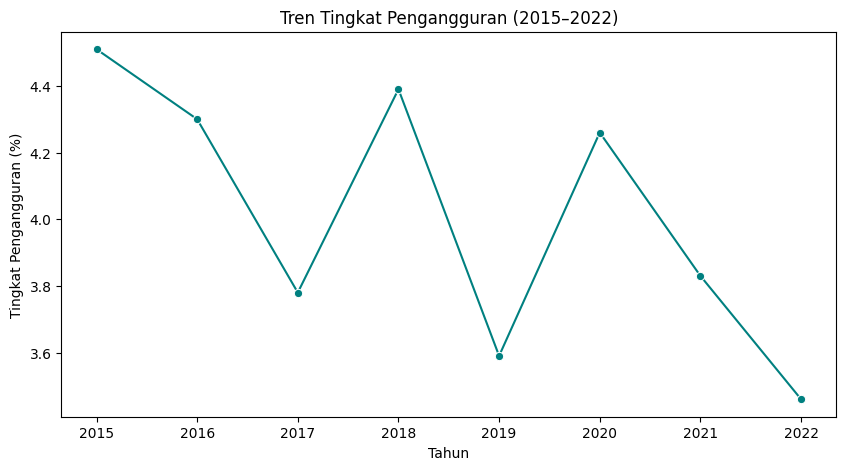

In [ ]:
# Tren Jumlah Pengangguran (2015-2022)
plt.figure(figsize=(10,5))
sns.lineplot(data=data, x='Year', y='Value', marker='o', color='teal')
plt.title("Tren Tingkat Pengangguran (2015–2022)")
plt.ylabel("Tingkat Pengangguran (%)")
plt.xlabel("Tahun")
plt.show()

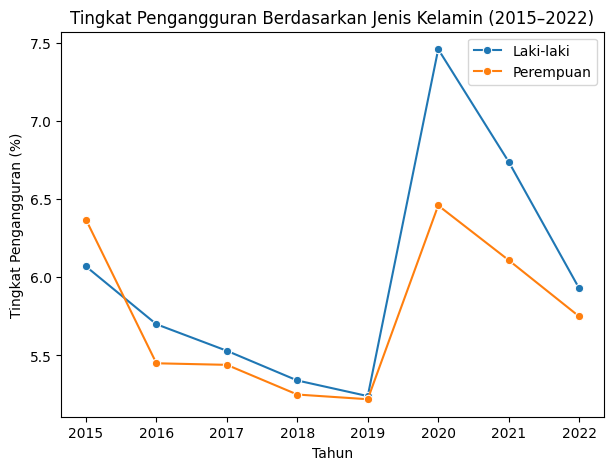

In [ ]:
# Analisis Jenis Kelamin terhadap Pengangguran
plt.figure(figsize=(7,5))
sns.lineplot(data=data, x='Year', y='Laki___Laki', label='Laki-laki', marker='o')
sns.lineplot(data=data, x='Year', y='Perempuan', label='Perempuan', marker='o')
plt.title("Tingkat Pengangguran Berdasarkan Jenis Kelamin (2015–2022)")
plt.ylabel("Tingkat Pengangguran (%)")
plt.xlabel("Tahun")
plt.legend()
plt.show()

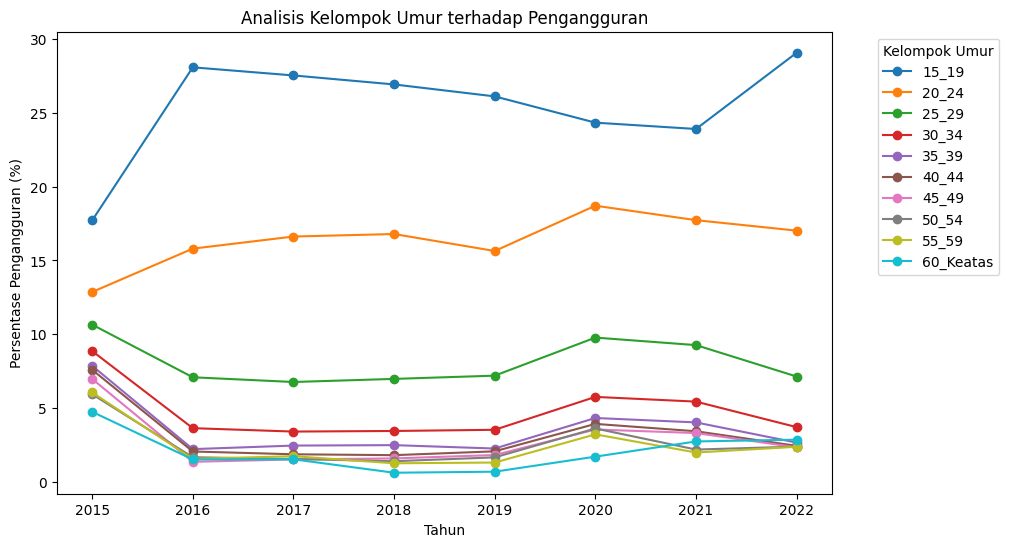

In [ ]:
# Analisis Kelompok Umur terhadap Pengangguran
umur_cols = ['15_19',	'20_24', '25_29',	'30_34',	'35_39',	'40_44',	'45_49',	'50_54',	'55_59',	'60_Keatas']

plt.figure(figsize=(10,6))
for col in umur_cols:
    plt.plot(data["Year"], data[col], marker='o', label=col)
plt.title("Analisis Kelompok Umur terhadap Pengangguran")
plt.xlabel("Tahun")
plt.ylabel("Persentase Pengangguran (%)")
plt.legend(title="Kelompok Umur", bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

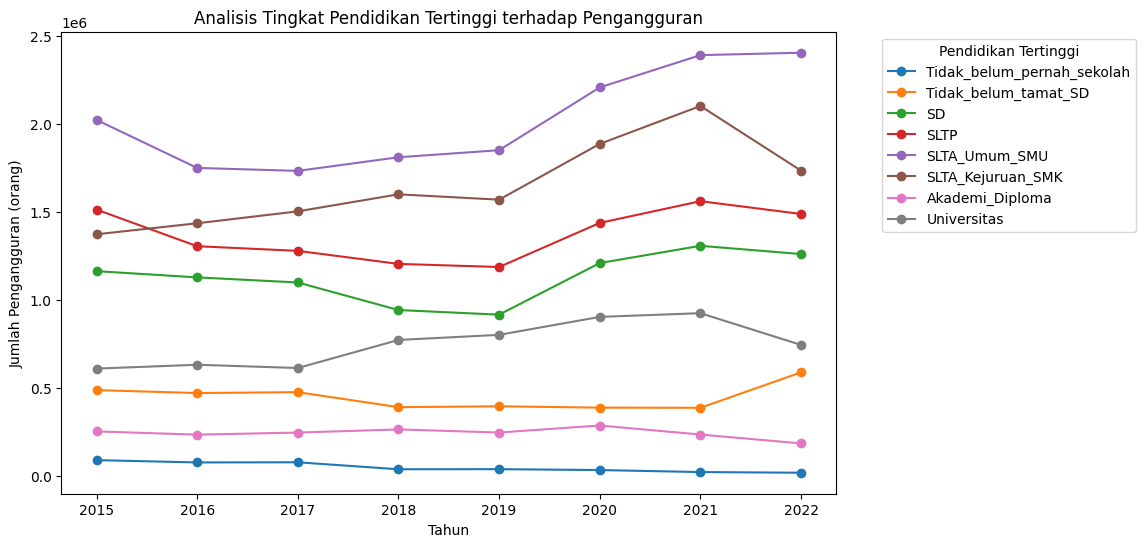

In [ ]:
# Analisis Tingkat Pendidikan Tertinggi terhadap Pengangguran
pendidikan_cols = ['Tidak_belum_pernah_sekolah',	'Tidak_belum_tamat_SD',
                   'SD','SLTP','SLTA_Umum_SMU','SLTA_Kejuruan_SMK','Akademi_Diploma','Universitas']

plt.figure(figsize=(10,6))
for col in pendidikan_cols:
    plt.plot(data["Year"], data[col], marker='o', label=col)
plt.title("Analisis Tingkat Pendidikan Tertinggi terhadap Pengangguran")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Pengangguran (orang)")
plt.legend(title="Pendidikan Tertinggi", bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()

Bar Chart

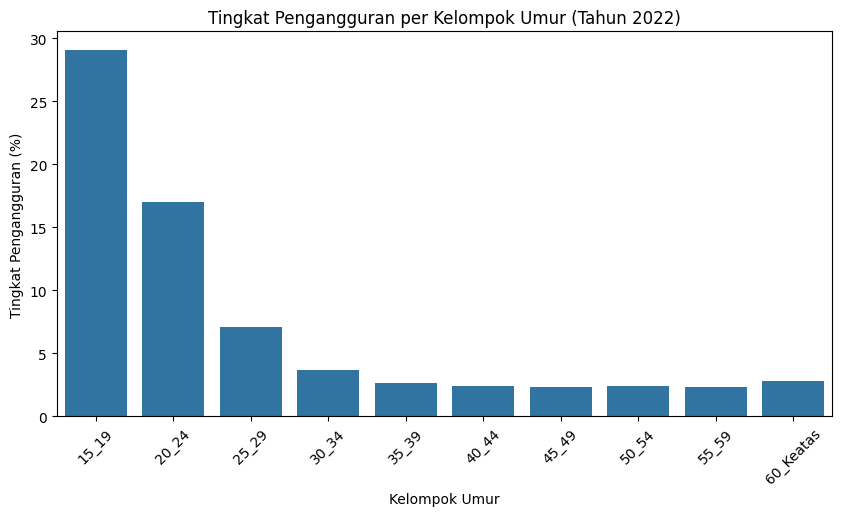

In [ ]:
# Analisis Kelompok Umur terhadap Pengangguran (2022)
df_2022 = data[data["Year"] == 2022]
umur_cols = ['15_19',	'20_24', '25_29',	'30_34',	'35_39',	'40_44',	'45_49',	'50_54',	'55_59',	'60_Keatas']

plt.figure(figsize=(10,5))
sns.barplot(x=umur_cols, y=df_2022[umur_cols].iloc[0])
plt.title("Tingkat Pengangguran per Kelompok Umur (Tahun 2022)")
plt.xlabel("Kelompok Umur")
plt.ylabel("Tingkat Pengangguran (%)")
plt.xticks(rotation=45)
plt.show()

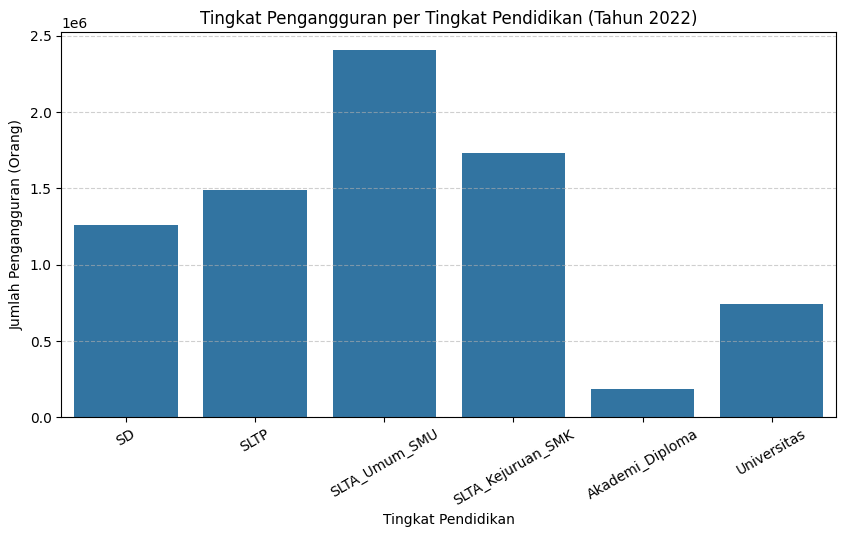

In [ ]:
# Analisis Tingkat Pendidikan Terakhir terhadap Pengangguran (2022)
df_2022 = df[df["Year"] == 2022]
pendidikan_cols = ["SD", "SLTP", "SLTA_Umum_SMU", "SLTA_Kejuruan_SMK",
                   "Akademi_Diploma", "Universitas"]
# Plot bar chart
plt.figure(figsize=(10,5))
sns.barplot(x=pendidikan_cols, y=df_2022[pendidikan_cols].iloc[0])
plt.title("Tingkat Pengangguran per Tingkat Pendidikan (Tahun 2022)")
plt.xlabel("Tingkat Pendidikan")
plt.ylabel("Jumlah Pengangguran (Orang)")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

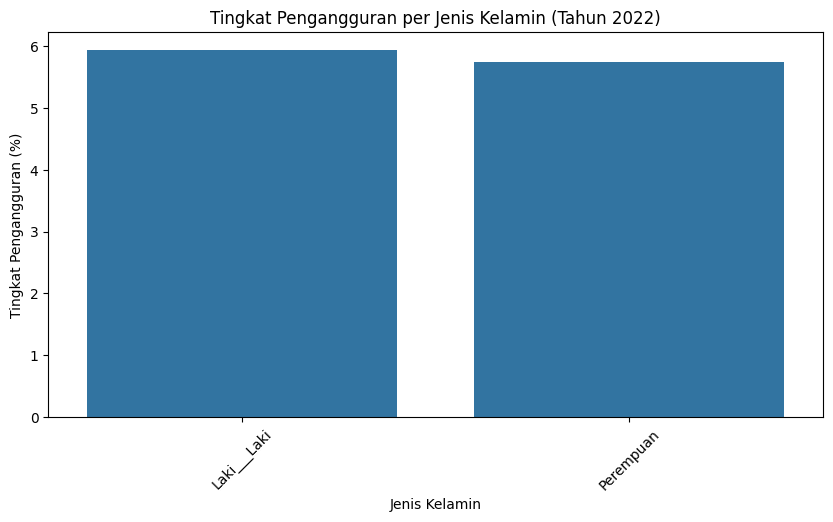

In [ ]:
# Analisis Jenis Kelamin terhadap Pengangguran (2022)
df_2022 = data[data["Year"] == 2022]
gender_cols = ['Laki___Laki',	'Perempuan']

plt.figure(figsize=(10,5))
sns.barplot(x=gender_cols, y=df_2022[gender_cols].iloc[0])
plt.title("Tingkat Pengangguran per Jenis Kelamin (Tahun 2022)")
plt.xlabel("Jenis Kelamin")
plt.ylabel("Tingkat Pengangguran (%)")
plt.xticks(rotation=45)
plt.show()

Stacked Bar Chart

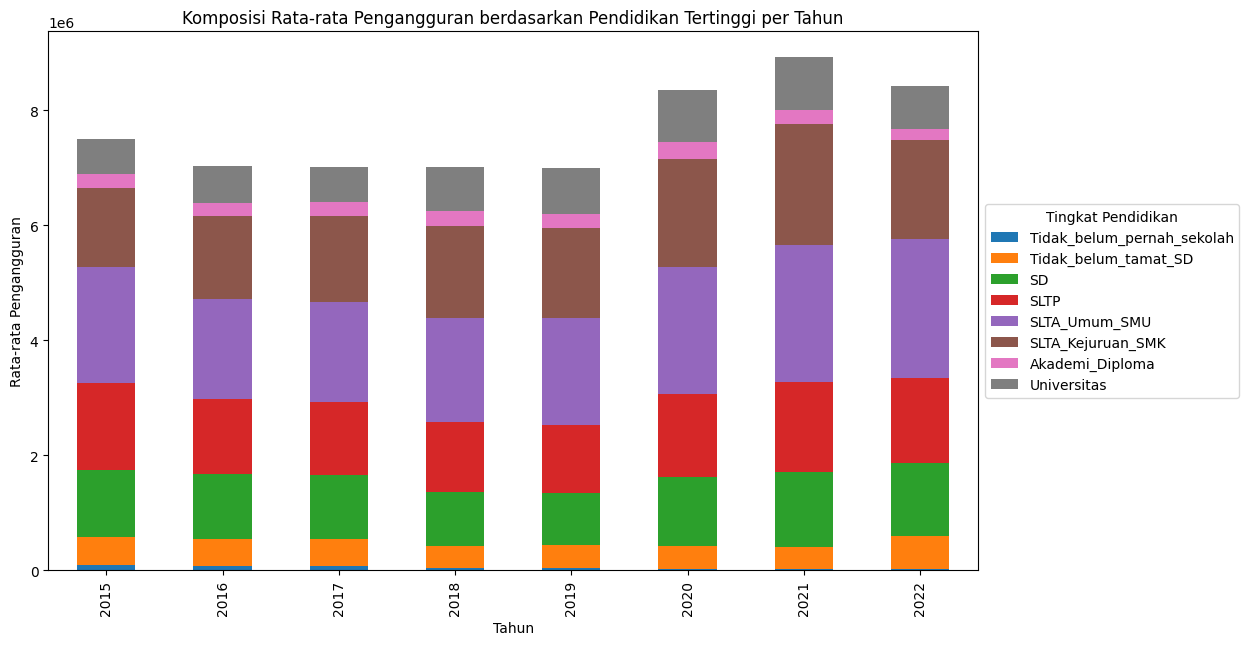

In [ ]:
pendidikan = [
    'Tidak_belum_pernah_sekolah',	'Tidak_belum_tamat_SD', 'SD','SLTP','SLTA_Umum_SMU','SLTA_Kejuruan_SMK',
        'Akademi_Diploma','Universitas'
]

data_plot = data[['Year'] + pendidikan].set_index('Year')

data_plot.plot(
    kind='bar',
    stacked=True,
    figsize=(12,7)
)

plt.title('Komposisi Rata-rata Pengangguran berdasarkan Pendidikan Tertinggi per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Pengangguran')
plt.legend(
    title='Tingkat Pendidikan',
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
plt.show()

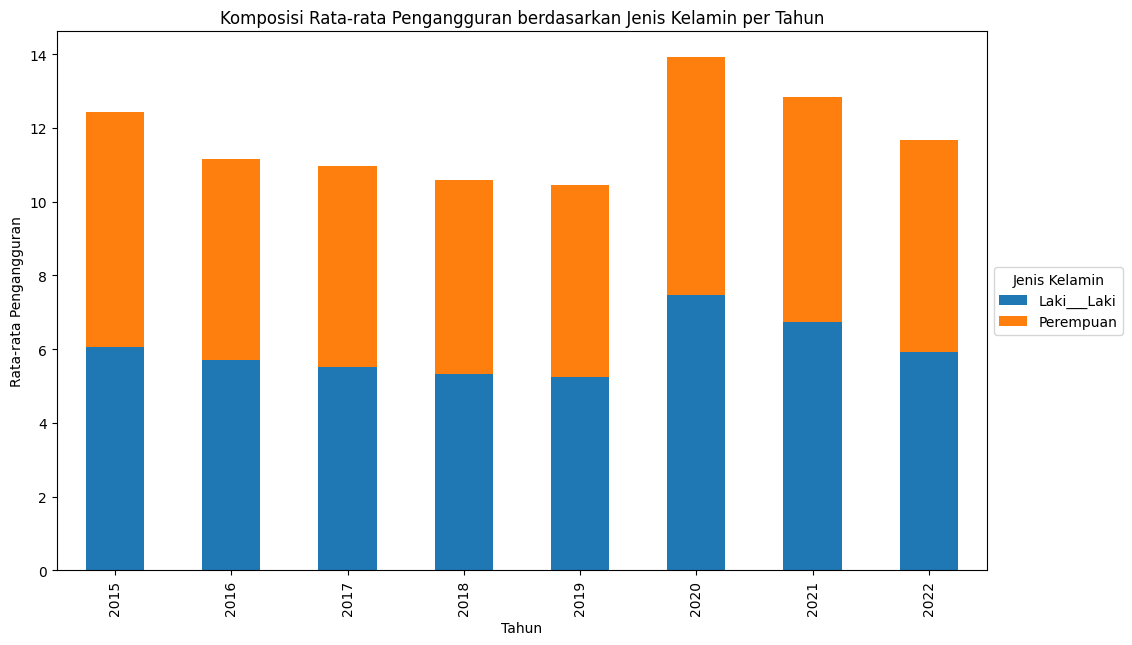

In [ ]:
gender = ['Laki___Laki',	'Perempuan']

data_plot = data[['Year'] + gender].set_index('Year')

data_plot.plot(
    kind='bar',
    stacked=True,
    figsize=(12,7)
)

plt.title('Komposisi Rata-rata Pengangguran berdasarkan Jenis Kelamin per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Pengangguran')
plt.legend(
    title='Jenis Kelamin',
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
plt.show()

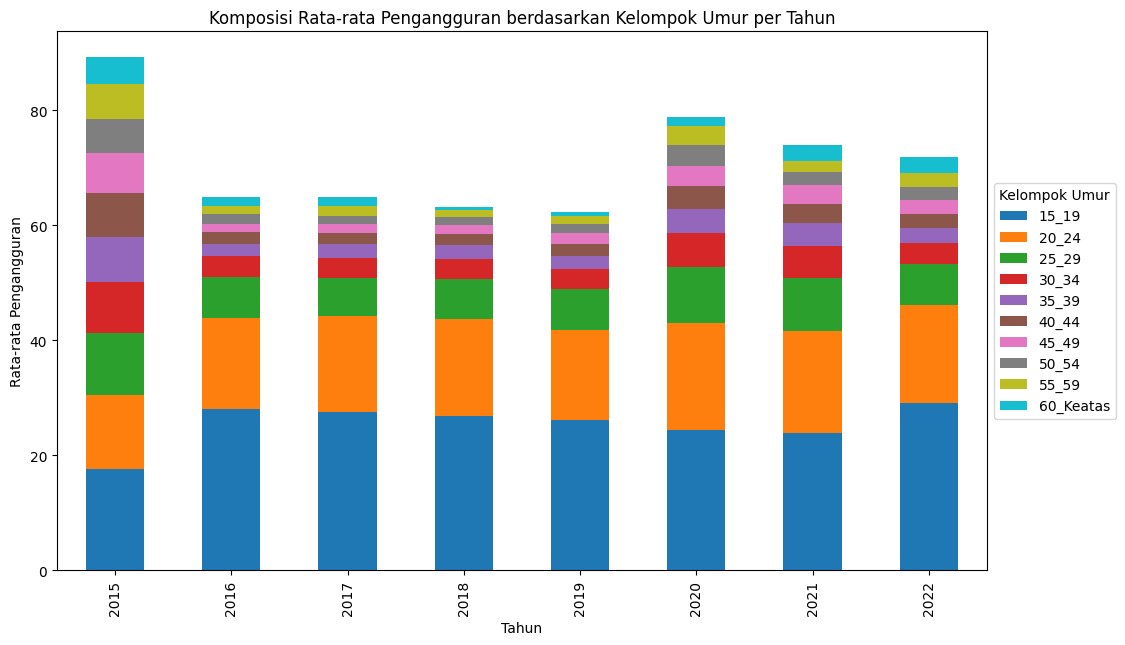

In [ ]:
age = ['15_19',	'20_24', '25_29',	'30_34',	'35_39',	'40_44',	'45_49',	'50_54',	'55_59',	'60_Keatas']

data_plot = data[['Year'] + age].set_index('Year')

data_plot.plot(
    kind='bar',
    stacked=True,
    figsize=(12,7)
)

plt.title('Komposisi Rata-rata Pengangguran berdasarkan Kelompok Umur per Tahun')
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Pengangguran')
plt.legend(
    title='Kelompok Umur',
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
plt.show()

Heatmap

<Axes: >

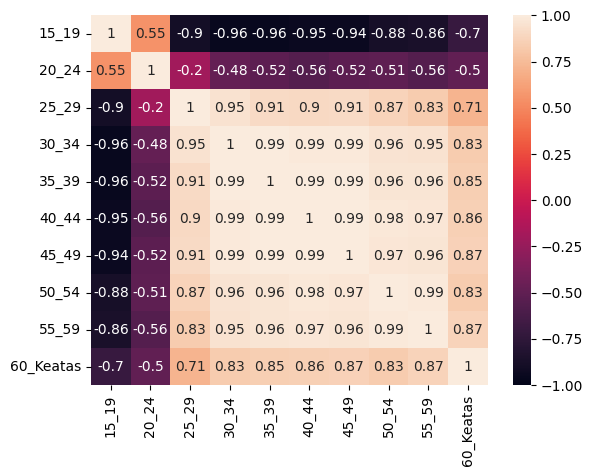

In [ ]:
import seaborn as sns
age_cols = ['15_19','20_24','25_29','30_34','35_39','40_44',
            '45_49','50_54','55_59','60_Keatas']

<Axes: >

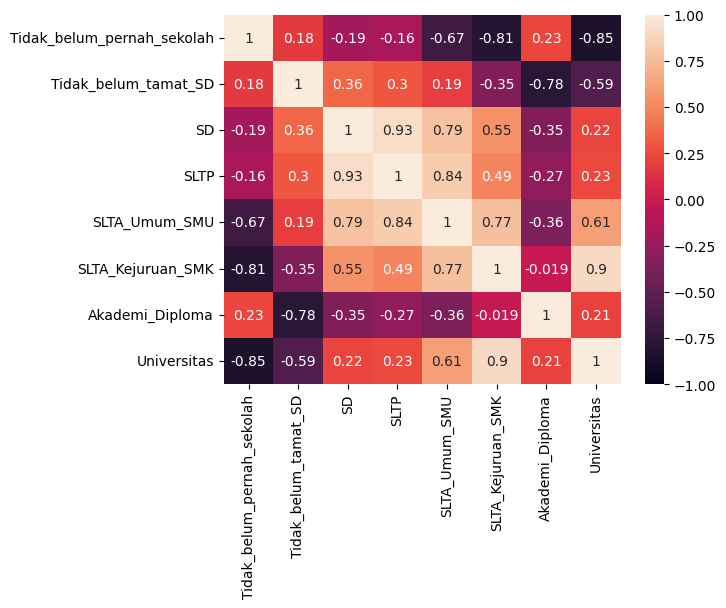

In [ ]:
edu_cols = ['Tidak_belum_pernah_sekolah','Tidak_belum_tamat_SD','SD','SLTP',
            'SLTA_Umum_SMU','SLTA_Kejuruan_SMK','Akademi_Diploma','Universitas']

sns.heatmap(data[edu_cols].corr(), vmin=-1, vmax=1, annot=True)

<Axes: >

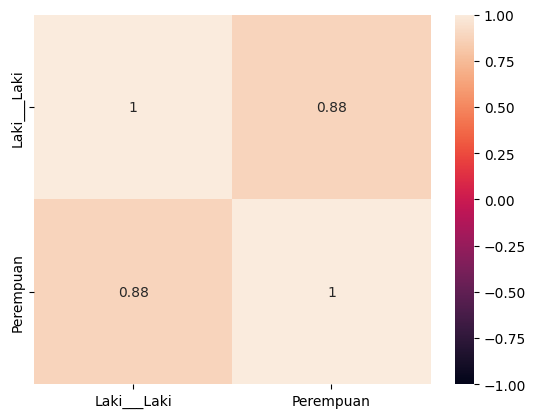

In [ ]:
gender_cols = ['Laki___Laki','Perempuan']

sns.heatmap(data[gender_cols].corr(), vmin=-1, vmax=1, annot=True)